In [54]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from datasets import load_dataset
import tqdm
from transformers import GPT2TokenizerFast, BertTokenizerFast
import re
import tiktoken
import numpy as np
from bus_nGPT import Decoder, TransformerLayer, AttentionHead, Rotary
import tensorboard as tb
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [14]:
import csv

x = []
y = []

with open('base_512_fullrun.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # Skip header if present
    for row in csvreader:
        x.append(float(row[1]))  # Assuming x is in the first column
        y.append(float(row[2]))  # Assuming y is in the second column


In [15]:
def remove_outliers(x, y):
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    mask = (y >= lower_bound) & (y <= upper_bound)
    return np.array(x)[mask], np.array(y)[mask]

x_clean, y_clean = remove_outliers(x, y)


In [16]:
x

[1.0,
 100.0,
 200.0,
 300.0,
 400.0,
 500.0,
 600.0,
 700.0,
 800.0,
 900.0,
 1000.0,
 1100.0,
 1200.0,
 1300.0,
 1400.0,
 1500.0,
 1600.0,
 1700.0,
 1800.0,
 1900.0,
 2000.0,
 2100.0,
 2200.0,
 2300.0,
 2400.0,
 2500.0,
 2600.0,
 2700.0,
 2800.0,
 2900.0,
 3000.0,
 3100.0,
 3200.0,
 3300.0,
 3400.0,
 3500.0,
 3600.0,
 3700.0,
 3800.0,
 3900.0,
 4000.0,
 4100.0,
 4200.0,
 4300.0,
 4400.0,
 4500.0,
 4600.0,
 4700.0,
 4800.0,
 4900.0,
 5000.0]

In [17]:
x_clean

array([ 200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
       1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900.,
       2000., 2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800.,
       2900., 3000., 3100., 3200., 3300., 3400., 3500., 3600., 3700.,
       3800., 3900., 4000., 4100., 4200., 4300., 4400., 4500., 4600.,
       4700., 4800., 4900., 5000.])

In [20]:
y_clean

array([5.79791975, 5.71323061, 5.62147951, 5.58574152, 5.49655199,
       5.46772575, 5.43948555, 5.42493868, 5.35012341, 5.31858444,
       5.33466625, 5.28206825, 5.23734426, 5.22355175, 5.12709284,
       5.13072968, 5.12743235, 5.09644651, 5.05150127, 5.02279711,
       5.02692032, 4.96997356, 4.99134827, 4.98092365, 4.92580414,
       4.91517115, 4.87730026, 4.85464954, 4.83703852, 4.85167789,
       4.77732038, 4.81324863, 4.77854919, 4.80211639, 4.78536224,
       4.72053003, 4.74282742, 4.73101807, 4.69938421, 4.70304871,
       4.72219181, 4.70531654, 4.75033283, 4.73621702, 4.69918728,
       4.68260193, 4.6792655 , 4.71579123, 4.68376923])

In [55]:
matplotlib.rcParams["axes.formatter.limits"] = (-99, 99)

/tmp/ipykernel_3237/744830094.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


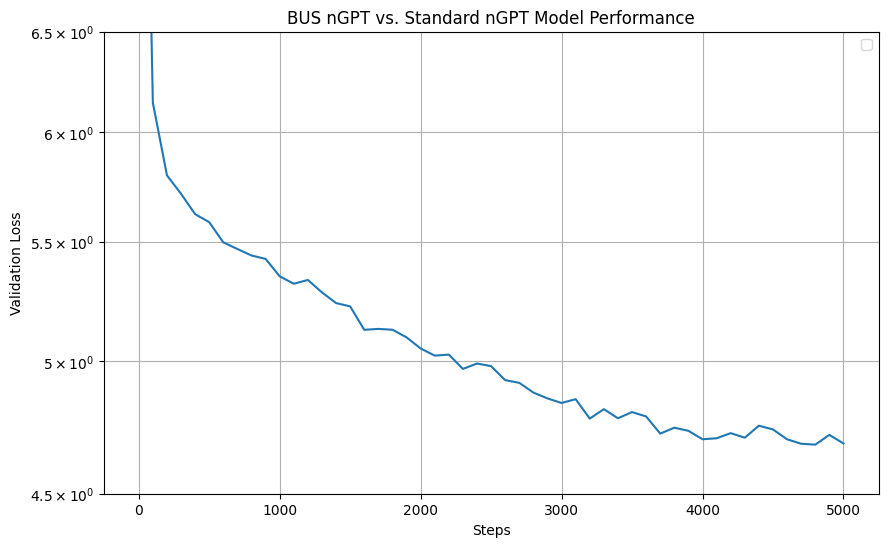

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.yscale('log')
# plt.ticklabel_format(scilimits=(-5,8))
plt.ylim([4.75, 6.25])
plt.xlabel('Steps')
plt.ylabel('Validation Loss')
plt.yticks([4.5, 5, 5.5, 6, 6.5])
plt.title('BUS nGPT vs. Standard nGPT Model Performance')
plt.grid(True)
plt.legend()
plt.show()


In [2]:
from transformers import Trainer, TrainingArguments, EvalPrediction

2024-11-29 22:35:49.166974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732941349.185029  202481 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732941349.190484  202481 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 22:35:49.208146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = load_dataset('stanfordnlp/snli')

In [4]:
tok = BertTokenizerFast.from_pretrained('google-bert/bert-base-uncased')

In [5]:
def tokenize_function(examples):
    return tok(examples["premise"] + examples['hypothesis'] , padding=False, return_tensors='pt')

In [6]:
def compute_acc(eval: EvalPrediction):
    return {
        'accuracy' : (np.argmax(
            eval.predictions,
            axis=1) == eval.label_ids).astype(
            np.float32).mean().item()
    }

In [7]:
test_tok = dataset.map(tokenize_function)

In [8]:
def abs_func(example):
    return {'label': example['label']} if example['label'] >= 0 else {'label':-example['label']}

test_tok = test_tok.map(abs_func, batched=False)

In [9]:
np.unique(test_tok['train']['label'], return_counts=True)

(array([0, 1, 2]), array([183416, 183549, 183187]))

In [10]:
model = torch.load('101M-512-std-model-512con.pt')
model.to('cuda')

training_args = TrainingArguments(
	output_dir="output", 
	evaluation_strategy="steps", 
	num_train_epochs = 2,
	warmup_steps = 10,
	logging_steps = 2000,
	save_steps = 2000,
	load_best_model_at_end = True,
	learning_rate = 5e-4,
    per_device_train_batch_size=64
	)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=test_tok['train'],
    eval_dataset=test_tok['validation'],
    tokenizer=tok,
    compute_metrics=compute_acc

)


/tmp/ipykernel_202481/1794072402.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('101M-512-std-model-512con.pt')
/home/brian/Desktop/school/extra/tran

In [11]:
trainer.train()

  0%|          | 0/17194 [00:00<?, ?it/s]

ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided ['label']

In [56]:
test_tok[0]

{'premise': 'This church choir sings to the masses as they sing joyous songs from the book at a church.',
 'hypothesis': 'The church has cracks in the ceiling.',
 'label': 1,
 'input_ids': [[101,
   2023,
   2277,
   6596,
   10955,
   2000,
   1996,
   11678,
   2004,
   2027,
   6170,
   6569,
   3560,
   2774,
   2013,
   1996,
   2338,
   2012,
   1037,
   2277,
   1012,
   1996,
   2277,
   2038,
   15288,
   1999,
   1996,
   5894,
   1012,
   102]],
 'token_type_ids': [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]],
 'attention_mask': [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1]]}

In [38]:
from torch.utils.data import DataLoader

In [ ]:
def col_fn(x):
    ids, lab = [], []
    for i in x:
        ids.append(i['input_ids'])
        lab.append(i['label'])
    return torch.tensor(ids), torch.tensor(lab)

In [52]:
DL = DataLoader(test_tok, batch_size=32, shuffle=True, collate_fn=col_fn)

In [53]:
for x in DL:
    print(x)
    break

[{'premise': 'A man is celebrating his victory while smiling and shooting champagne in the air with his teammate.', 'hypothesis': 'A man is celebrating his victory while smiling and shooting champagne in the air', 'label': 0, 'input_ids': [101, 1037, 2158, 2003, 12964, 2010, 3377, 2096, 5629, 1998, 5008, 12327, 1999, 1996, 2250, 2007, 2010, 10809, 1012, 1037, 2158, 2003, 12964, 2010, 3377, 2096, 5629, 1998, 5008, 12327, 1999, 1996, 2250, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, {'premise': 'An emergency worker directs a man pulling a sled with emergency equipment on a snowy path.', 'hypothesis': 'An emergency worker works at a crash scene.', 'label': 1, 'input_ids': [101, 2019, 5057, 7309, 23303, 1037, 2158, 4815, 1037, 22889, 2098, 2007, 5057, 3941, 2006, 1037, 20981, 4130, 1012

TypeError: list indices must be integers or slices, not str

In [21]:
# data = load_dataset('Salesforce/wikitext', 'wikitext-103-raw-v1')
# data1 = load_dataset('Skylion007/openwebtext')
data = load_dataset('bookcorpus/bookcorpus')


In [40]:
torch.cuda.is_bf16_supported()

True

In [22]:
data

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 74004228
    })
})

In [23]:
data['train'].__getitem__(3)

{'text': "he 'd seen the movie almost by mistake , considering he was a little young for the pg cartoon , but with older cousins , along with her brothers , mason was often exposed to things that were older ."}

In [24]:
train = data['train']
# validation = data['validation']
# test = data['test']
# validation_owt = data1['train']['text'][int(0.8*len(data1['train']['text']))+1:int(0.9*len(data1['train']['text']))]
# test_owt = data1['train']['text'][int(0.9*len(data1['train']['text']))+1:]
# train_owt = data1['train']['text'][:int(0.8*len(data1['train']['text']))]

In [26]:
train

Dataset({
    features: ['text'],
    num_rows: 74004228
})

In [27]:
bos_token = "<|BOS|>"

In [ ]:

def data_clean(input: list[str], seq_len=135) -> str:
    ret = ""
    for line in input:
        if len(line) == 0:  continue
        # remove @'s surrounding some characters
        line = re.sub(r' @([.,\-])@ ', r'\1', line)
        # find titles of articles and add bos_token
        matches = re.match(r'^ = ?(.+?) =?\n', line)    # this finds all title and subsection text
        if matches != None:
            c = line.count('=')
            if c == 2:
                # start new article
                ret += " " + bos_token
        ret += line

    ret = ret.split(" ")
    chunks = []
    curr_chunk = []
    cur_len = 0
    
    for word in ret:
        if cur_len > seq_len:
            chunks.append(" ". join(curr_chunk))
            curr_chunk = [word]
            cur_len = 1

        else:
            curr_chunk.append(word)
            cur_len += 1

    return chunks

In [39]:
tokenizer = tiktoken.get_encoding('gpt2')

In [ ]:
train_join = data_clean(train['text']) + data_clean(train_owt)
# val_join = data_clean(validation['text']) + data_clean(validation_owt)
# test_join = data_clean(test['text']) + data_clean(test_owt)

In [29]:
def token_all(ex):
    return tokenizer(ex['text'], truncation=False, padding=False)

In [32]:
tok_dataset = train.map(token_all, batched=True, remove_columns=train.column_names)

Map:   0%|          | 0/74004228 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1119 > 1024). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

In [ ]:
class CombinedSentenceDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_dataset, max_length=128):
        self.tokenized_dataset = tokenized_dataset
        self.max_length = max_length
        self.samples = self._create_samples()

    def _create_samples(self):
        samples = []
        current_sample = []
        current_length = 0

        for sentence in self.tokenized_dataset["input_ids"]:
            sentence_length = len(sentence)

            if current_length + sentence_length <= self.max_length:
                current_sample.extend(sentence)
                current_length += sentence_length
            else:
                if current_length > 0:
                    # Pad the current sample if needed
                    padding_length = self.max_length - current_length
                    current_sample.extend([tokenizer.pad_token_id] * padding_length)
                    samples.append(current_sample)

                # Start a new sample with the current sentence
                current_sample = sentence[:self.max_length]
                current_length = min(sentence_length, self.max_length)

            # If we've reached exactly max_length, add the sample and reset
            if current_length == self.max_length:
                samples.append(current_sample)
                current_sample = []
                current_length = 0

        # Add the last sample if it's not empty
        if current_length > 0:
            padding_length = self.max_length - current_length
            current_sample.extend([tokenizer.pad_token_id] * padding_length)
            samples.append(current_sample)

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.samples[idx])
        attention_mask = (input_ids != tokenizer.pad_token_id).long()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }

# Create the combined sentence dataset
combined_dataset = CombinedSentenceDataset(tokenized_dataset)


In [ ]:
train_tok = [tokenizer(chunk, truncation=False, return_tensors='pt')['input_ids'] for chunk in tqdm.tqdm(train)]
# val_tok = [tokenizer(chunk, max_length=129, truncation=True, return_tensors='pt')['input_ids'] for chunk in val_join]
# test_tok = [tokenizer(chunk, max_length=129, truncation=True, return_tensors='pt')['input_ids'] for chunk in test_join]

100%|██████████| 737084/737084 [05:41<00:00, 2156.80it/s]


In [ ]:
torch.save(train_tok, 'data/train_data_bookcorp.pt')
# torch.save(val_tok, 'data/val_data_token_owt.pt')
# torch.save(test_tok, 'data/test_data_token_owt.pt')

In [ ]:
len(train_tok)

737084